In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from bilby.gw.detector import PowerSpectralDensity
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

np.random.seed(1)
from dingo.gw.domains import build_domain, MultibandedFrequencyDomain
from dingo.gw.domains.multibanded_frequency_domain import get_band_nodes_for_adaptive_decimation
from dingo.gw.prior import build_prior_with_defaults
from dingo.gw.waveform_generator import WaveformGenerator
from dingo.gw.dataset.generate_dataset import generate_parameters_and_polarizations

The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


# Multibanding: How to define the bands for PhenomXPHM waveforms?
(based on a notebook from Max, see [this commit](https://github.com/dingo-gw/dingo-development/commit/38f9b86027848fe709cf053f68c979ea61b1b4e9))

In the DINGO-BNS paper, the bands for multibanding are defined based on the periods of the waveform, implemented via zero-crossings.
The bands were chosen such that each period is covered by at least 32 bins.

However, this approach does not work for precessing waveforms like `IMRPhenomXPHM` since the waveform might not cross zero in every period. This notebook explores a different implementation for finding the bands based on the difference of the data in the multibanded frequency domain (mfd) $\overline{d_j^w}$ and the data in the uniform frequency domain (ufd) evaluated at the mfd frequency values $\overline{f_i}$.

In the Appendix of the DINGO-BNS paper ([arXiv:2407.09602v2](https://arxiv.org/abs/2407.09602v2)), multibanding is explained in detail.
The whole argument for multibanding is based on the Whittle likelihood (in mfd) which reads

$$
\log p(d|\theta) \approx -\frac{1}{2}\sum_j \frac{|\overline{d_j^w} - \overline{h_j^w}(\theta)|^2}{\sigma_{i(j)}^2\cdot \overline{S_j}}
$$

where $j$ indexes the mfd bins, $\overline{S_j}$ denotes the averaged PSD over the decimation window associated with mfd bin j, and $\sigma_{i(j)} = \sqrt{\frac{w}{4\Delta f_i}}$ is computed based on the frequency resolution  in bin $i$ of the decimation window associated with $j$, and the window factor $w$.

For the BNS paper, Max investigated in [`binary_neutron_stars/prototyping/psd_decimation.ipynb`](https://github.com/dingo-gw/dingo-development/blob/bns_add_dingo_pipe_max/binary_neutron_stars/prototyping/psd_decimation.ipynb) that the data should be whitened in the base domain and decimated afterward. This notebook also contains more details about decimating the ASD.

In [2]:
# Build domain
uniform_frequency_domain_settings = {
    "type": "FrequencyDomain",
    "f_min": 20,
    "f_max": 1024,
    "delta_f": 1 / 8,
    "window_factor": 1.0,
}
ufd = build_domain(uniform_frequency_domain_settings)

# Build prior
intrinsic_prior_settings = {
    "mass_1": "bilby.core.prior.Constraint(minimum=10, maximum=120)",
    "mass_2": "bilby.core.prior.Constraint(minimum=10, maximum=120)",
    "chirp_mass": "bilby.gw.prior.UniformInComponentsChirpMass(minimum=15, maximum=120)",
    "mass_ratio": "bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1.0)",
    "phase": "default",
    "a_1": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "a_2": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "tilt_1": "default",
    "tilt_2": "default",
    "phi_12": "default",
    "phi_jl": "default",
    "theta_jn": "default",
    "luminosity_distance": "100.0",
    "geocent_time": "0.0",
}
prior = build_prior_with_defaults(intrinsic_prior_settings)

# Generate waveforms
To obtain a reasonable estimate for the error introduced by multibanding, we generate a set of waveforms in the ufd.

We will decimate these waveforms to the mfd with decimation factors [1,2,4,8,16]. A decimation factor of 1 means that we will keep each frequency bin from ufd, while a factor of 2 means that we will compute the mean of the waveform within a decimation window containing 2 frequency bins of the ufd ($[f_0, f_1] \rightarrow [f_{1/2}]$). If we want to compare the decimated waveform to the waveform in ufd, we need to evaluate the waveform the mfd frequency values (i.e. $f_{1/2}$). While nothing changes for a decimation factor of 1, the frequency values in the mfd are right in the middle of two ufd frequency values for a decimation window of 2 ($f_{1/2} = 0.5 \cdot (f_0 + f_1)$). (For 4, they are right between $f_1$ and $f_2$ for $[f_0, f_1, f_2, f_3]$, etc.)

This means that we need a reference waveform dataset with **twice** the resolution of the base domain.

In [3]:
# Generate waveforms in a domain with twice the resolution of ufd, such that we can later compare the decimated mfd waveforms to the high-resolution waveform as a reference.
# wfg_settings = {"approximant": "IMRPhenomPv2", "f_ref": 10}
wfg_settings = {"approximant": "IMRPhenomXPHM", "f_ref": 10}
num_samples = 1000
num_processes = 10
ufd_twice_res = build_domain({**ufd.domain_dict, **{"delta_f": ufd.domain_dict["delta_f"] / 2}})
assert (ufd_twice_res()[::2] == ufd()).all()
waveform_generator = WaveformGenerator(domain=ufd_twice_res, **wfg_settings)
parameters, polarizations_twice_res = generate_parameters_and_polarizations(
    waveform_generator, prior, num_samples, num_processes
)
# Down-sample polarization to match standard ufd resolution
polarizations = {k: v[...,::2] for k, v in polarizations_twice_res.items()}
assert polarizations["h_plus"][0].shape == ufd().shape

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Generating dataset of size 1000
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.
The pyseobnr packa

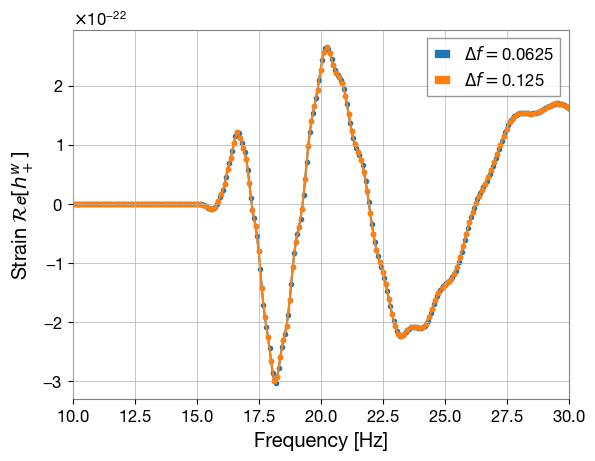

In [4]:
plt.plot(ufd_twice_res(), polarizations_twice_res["h_plus"][0].real, "-o", markersize=3, label=r"$\Delta f=$"+f"{ufd.domain_dict["delta_f"] / 2}")
plt.plot(ufd(), polarizations["h_plus"][0].real, "-o", markersize=3, label=r"$\Delta f=$"+f"{ufd.domain_dict["delta_f"]}")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Strain $\mathcal{Re}[h_+^w]$")
plt.xlim(10, 30)
plt.legend()
plt.show()

# Load ASD
Load design sensitivity curve for LIGO because it is the most conservative estimate for noise: If the noise were larger, the likelihood is inversely affected by it which means that the likelihood would get smaller (in absolute values). As a result, using the design sensitivity PSD is the most conservative estimate for finding the nodes in multi-banding. (With a larger noise PSD, there is less information content in each band, meaning we could in principle make it larger than it is.)

This also motivates why it is save to remove spectral lines which makes the estimation of the bands smoother.

In [5]:
asd_file = "aLIGO_ZERO_DET_high_P_asd.txt"
psd = PowerSpectralDensity(asd_file=asd_file)
asd_interp = interp1d(psd.frequency_array, psd.asd_array, bounds_error=False, fill_value=np.inf)
asd_twice_res = asd_interp(ufd_twice_res.sample_frequencies)
# Remove the bump
asd_twice_res[np.where((ufd_twice_res() > 477) & (ufd_twice_res() < 483))[0]] = asd_twice_res[np.argmin(np.abs(ufd_twice_res() - 477))]
# Down-sample ASD to match standard ufd resolution
asd = asd_twice_res[::2]
assert polarizations["h_plus"][0].shape == ufd().shape == asd.shape

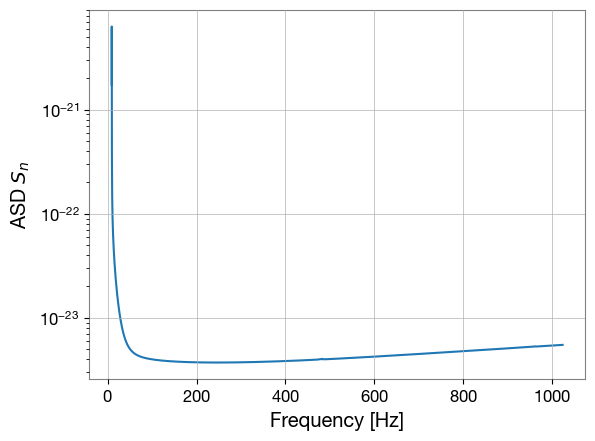

In [6]:
plt.plot(ufd(), asd)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"ASD $S_n$")
plt.yscale("log")
plt.show()

# How to determine the bands?
### Previously:
* Calculate period (i.e. zero-crossings) for each ufd bin based on real part of each waveform
* Obtain minimal period for each ufd frequency bin (replace min by first percentile to make it more stable)
* Define maximally allowed decimation as periods / min_bins_per_period=32 ($\rightarrow$ each period is covered by at least 32 mfd frequency bins)

### Now:
* Decimate whitened waveforms based on range of decimation factors (using convolution)
* Calculate the difference between the decimated whitened waveform and the whitened waveform in the ufd
* Define maximally allowed decimation through threshold value for the difference

### How to define the convolution:
1. Convolution with stride=1:
not suitable because this calculates the mean of each pair of neighboring bins (i.e. [1, 2, 3] -> [1.5, 2.5]), thus not reducing the dimensionality of the data by decimation_factor
2. Convolution with stride=decimation_factor:
what we want

Input data: (1000, 8193)
Conv with stride=1: (1000, 8193)
Conv with stride=decimation_factor: torch.Size([1000, 1024])


/var/folders/3s/k8hkbxc95rs93_htsl1k_sb00002q4/T/ipykernel_82882/3482888962.py:12: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  conv = lambda d: torch.nn.functional.conv1d(


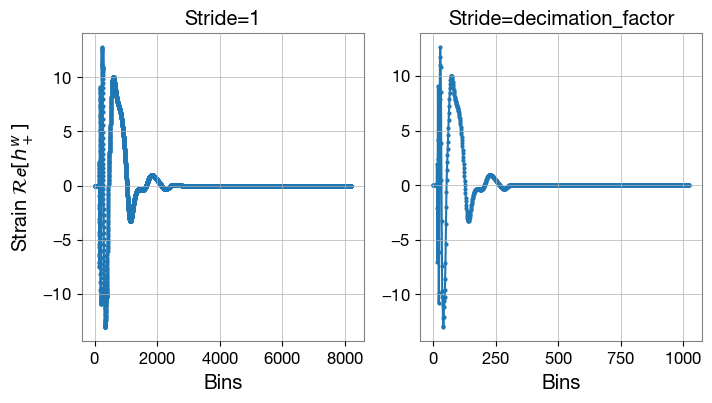

In [7]:
decimation_factor = 8

# Whiten
d = polarizations["h_plus"] / asd / ufd.noise_std
d = d.real
print("Input data:", d.shape)

# Construct convolution kernel
kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor

# Pad with "same", stride=1 -> mean calculated of each pair of neighboring bins -> len not reduced by decimation_factor
conv = lambda d: torch.nn.functional.conv1d(
    torch.tensor(d, dtype=torch.float64)[:, None, :], 
    kernel, 
    padding="same", 
    dilation=1
).squeeze()
d_new = np.array(conv(d))
print("Conv with stride=1:", d_new.shape)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(d_new[0], "-o", markersize=2)
axs[0].set_title("Stride=1")
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+^w]$")

# Pad with 0, stride = decimation_factor
conv = lambda d: torch.nn.functional.conv1d(
    torch.tensor(d, dtype=torch.float64)[:, None, :], 
    kernel, 
    padding=0,
    stride=decimation_factor,
).squeeze()
d_new = conv(d)
print("Conv with stride=decimation_factor:", d_new.shape)
axs[1].plot(d_new[0], "-o", markersize=2)
axs[1].set_title("Stride=decimation_factor")
for ax in axs:
    ax.set_xlabel("Bins")

### How to quantify the deviation introduced by multibanding:
1. **Compare decimated waveform value to all waveform values in the ufd (within the corresponding decimation window)**:
Repeat the mfd data value (= mean over multiple ufd bins) to match the number of bins per decimation window in the ufd and compare. Taking the max of this would result in computing the maximal deviation per mfd bin (=ufd decimation window). 
2. **Compare the mfd waveform value to the true ufd waveform value at the mfd frequency (i.e. evaluate waveform at center of ufd decimation window)**.
This means that we apply a convolution to the frequency values in the ufd to get the mfd frequency values (= mean of frequencies in each decimation window) and evaluate the waveform at these mfd frequency values. Therefore, we are comparing the decimated waveform to the true waveform only at the center of the decimation window. The disadvantage of this approach is that it will not flag cases where the waveform in the left half of the decimation window has opposite sign but same magnitude compared to the right half of the window. In such a case, contributions to the mean with opposite sign and magnitude cancel out, but the decimated waveform aligns with the waveform evaluated at the center of the decimation window.

### Investigate difference of 1. and 2. for one specific signal

In [8]:
# decimation_factors = [1, 2, 4, 8, 16, 32]
decimation_factors = 2 ** np.arange(8)
f = ufd()

 # Whiten
d = polarizations["h_plus"] / asd / ufd.noise_std
d = d.real
d_full = polarizations_twice_res["h_plus"] / asd_twice_res / ufd.noise_std  # not ufd_full!
d_full = d_full.real
assert f.shape == d[0].shape

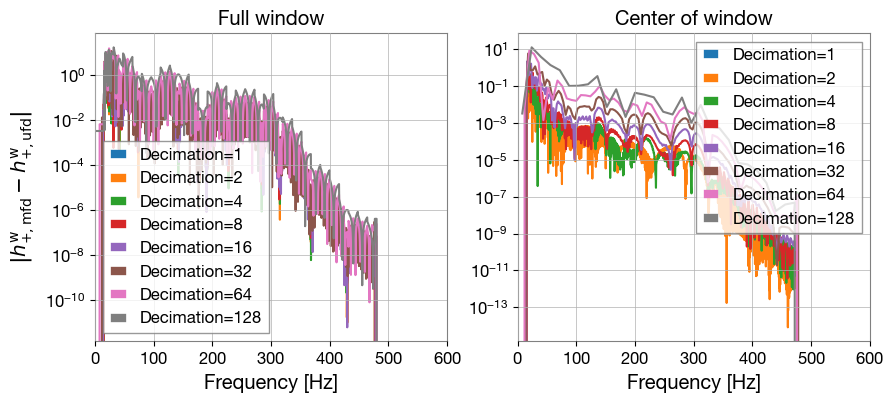

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    d_conv = conv(d)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    d_ref = d
    f_ref = f
    d_new = np.repeat(np.array(d_conv), decimation_factor, axis=-1)
    n_pad = d_ref.shape[1] - d_new.shape[1]
    d_new = np.pad(d_new, ((0, 0), (0,n_pad)), 'constant', constant_values=0)
    diff = np.abs(d_ref - d_new)
    # Plot
    axs[0].plot(f_ref, diff[0], label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(f[None, :])
    inds_ref = (f_ref / ufd_twice_res.delta_f).type(torch.int32)
    d_ref = d_full[:, inds_ref]
    d_new = np.array(d_conv)
    diff = np.abs(d_ref - d_new)
    # Plot
    axs[1].plot(f_ref, diff[0], label=f"Decimation={decimation_factor}")
    
axs[0].set_title("Full window")
axs[1].set_title("Center of window")
axs[0].set_ylabel(r"$\left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
for ax in axs:
    ax.set_xlabel("Frequency [Hz]")
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim(0,600)

## Compare max and 95th percentile for 1. and 2.

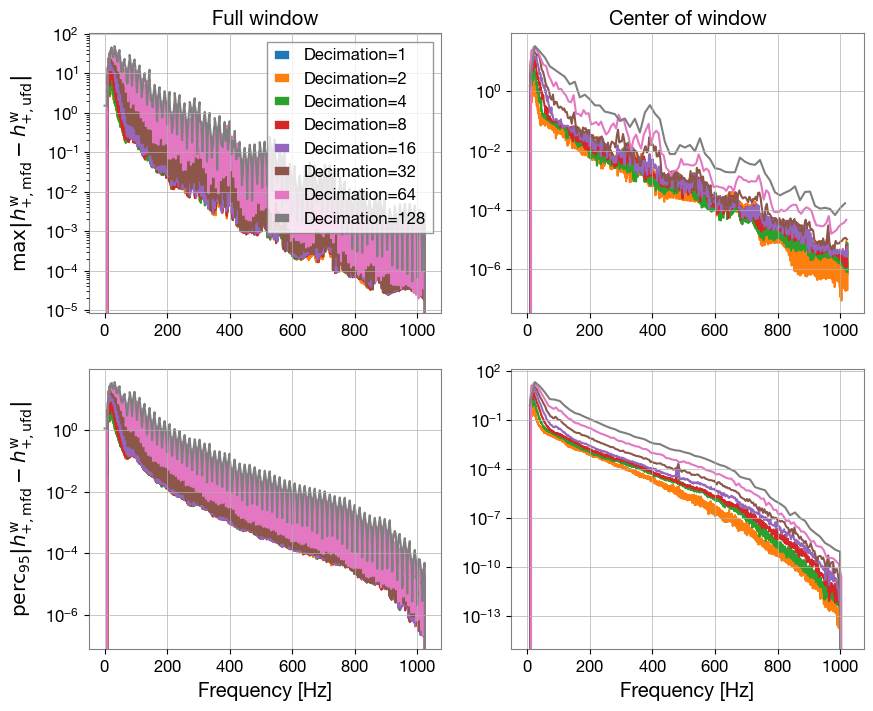

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    d_conv = conv(d)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    d_ref = d
    f_ref = f
    d_new = np.repeat(np.array(d_conv), decimation_factor, axis=-1)
    n_pad = d_ref.shape[1] - d_new.shape[1]
    d_new = np.pad(d_new, ((0, 0), (0,n_pad)), 'constant', constant_values=0)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_perc = np.percentile(diff, 99, axis=0)
    # Plot
    axs[0,0].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,0].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(f[None, :])
    inds_ref = (f_ref / ufd_twice_res.delta_f).type(torch.int32)
    d_ref = d_full[:, inds_ref]
    d_new = np.array(d_conv)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_perc = np.percentile(diff, 95, axis=0)
    # Plot
    axs[0,1].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,1].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
axs[0,0].set_title("Full window")
axs[0,1].set_title("Center of window")
axs[0,0].set_ylabel(r"$\max \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_ylabel(r"$\mathrm{perc}_{95} \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[0,0].legend()
for ax in axs.flatten():
    ax.set_yscale('log')
    #ax.set_xlim(0,800)

## Compare accumulated difference (max and percentile) for 1. and 2.

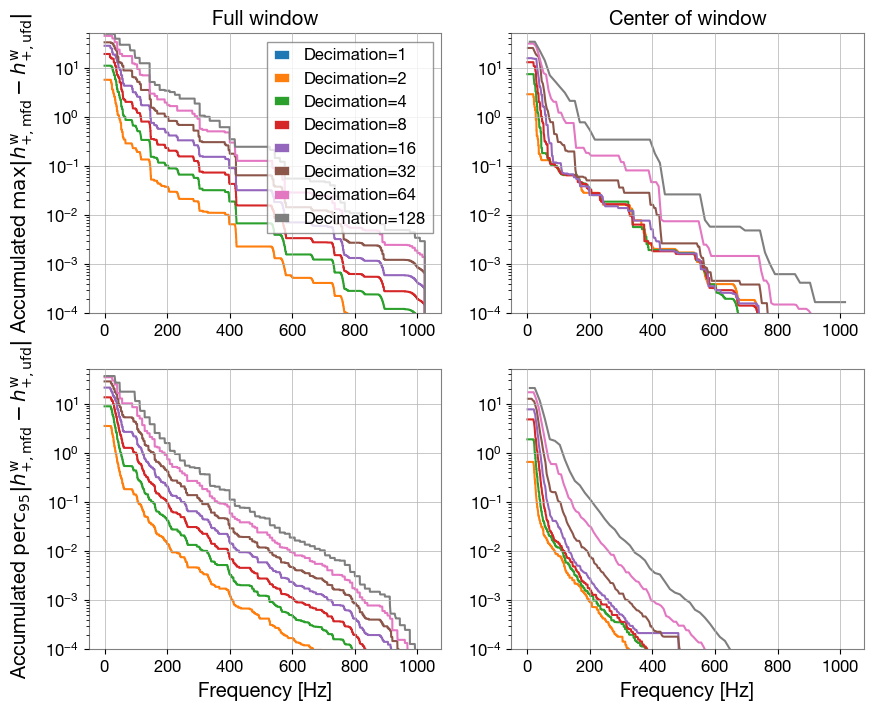

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    d_conv = conv(d)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    d_ref = d
    f_ref = f
    d_new = np.repeat(np.array(d_conv), decimation_factor, axis=-1)
    n_pad = d_ref.shape[1] - d_new.shape[1]
    d_new = np.pad(d_new, ((0, 0), (0,n_pad)), 'constant', constant_values=0)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_max = np.maximum.accumulate(diff_max[..., ::-1], axis=-1)[..., ::-1]
    diff_perc = np.percentile(diff, 99, axis=0)
    diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
    # Plot
    axs[0,0].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,0].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    f_ref = conv(f[None, :])
    inds_ref = (f_ref / ufd_twice_res.delta_f).type(torch.int32)
    d_ref = d_full[:, inds_ref]
    d_new = np.array(d_conv)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_max = np.maximum.accumulate(diff_max[..., ::-1], axis=-1)[..., ::-1]
    diff_perc = np.percentile(diff, 95, axis=0)
    diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
    # Plot
    axs[0,1].plot(f_ref, diff_max, label=f"Decimation={decimation_factor}")
    axs[1,1].plot(f_ref, diff_perc, label=f"Decimation={decimation_factor}")
    
axs[0,0].set_title("Full window")
axs[0,1].set_title("Center of window")
axs[0,0].set_ylabel(r"Accumulated $\max \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_ylabel(r"Accumulated $\mathrm{perc}_{95} \left|h^\mathrm{w}_\mathrm{+,mfd} - h^\mathrm{w}_\mathrm{+,ufd}\right|$")
axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[0,0].legend()
for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(1.e-4, 50)

We can observe that calculating the difference between the multibanded waveform and the original waveform over the full window is more conservative in the estimate than comparing at the center of the decimation window.

Using the full window with the max as a metric seems too strict since e.g. a threshold of $10^{-2}$ would not allow a decimation factor of 128 to be used.

Comparing max to 95th percentile, the maximum is less smooth.

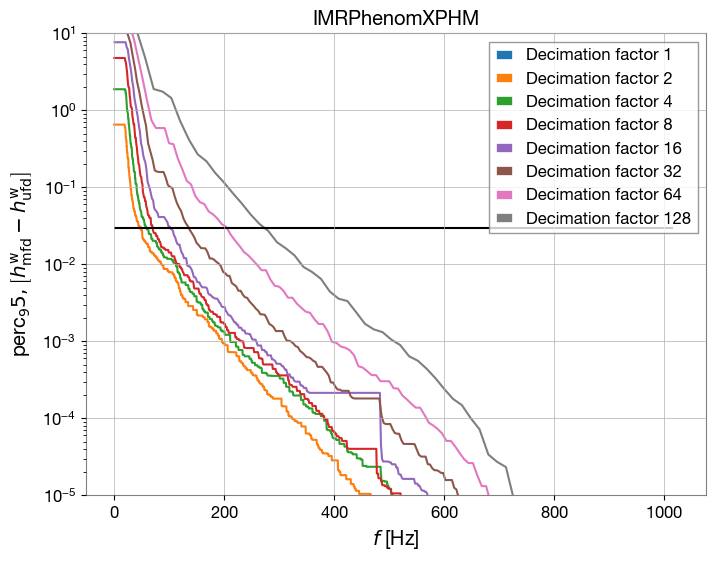

In [12]:
calc_dev_full_window = False
ufd = build_domain(uniform_frequency_domain_settings)

fig = plt.figure()
plt.title(wfg_settings["approximant"])
fig.set_size_inches(8,6)
diffs_per_decimation_factor = []
diffs_max_per_decimation_factor = []
freqs_per_decimation_factor = []
# decimation_factors = [1, 2, 4, 8, 16, 32]
decimation_factors = 2 ** np.arange(8)
f = ufd()

 # Whiten
d = polarizations["h_plus"] / asd / ufd.noise_std
d = d.real
d_full = polarizations_twice_res["h_plus"] / asd_twice_res / ufd.noise_std  # not ufd_full!
d_full = d_full.real

assert f.shape == d[0].shape
    
for decimation_factor in decimation_factors:
    # Construct convolution kernel
    kernel = torch.ones((1, 1, decimation_factor), dtype=torch.float64) / decimation_factor
    conv = lambda d: torch.nn.functional.conv1d(
        torch.tensor(d, dtype=torch.float64)[:, None, :], 
        kernel, 
        padding=0,
        stride=decimation_factor,
    ).squeeze()
    d_new = conv(d)

    # Compares the decimated value to all values within the decimation window
    # (most conservative estimate for difference between original and decimated data)
    if calc_dev_full_window:
        d_ref = d
        f_ref = f
        d_new = np.repeat(np.array(d_new), decimation_factor, axis=-1)
        n_pad = d_ref.shape[1] - d_new.shape[1]
        d_new = np.pad(d_new, ((0, 0), (0,n_pad)), 'constant', constant_values=0)
    # Compares the decimated value only to the waveform value at the frequency value in the middle of each band
    else:
        f_ref = conv(f[None, :])
        inds_ref = (f_ref / ufd_twice_res.delta_f).type(torch.int32)
        d_ref = d_full[:,inds_ref]
    d_new = np.array(d_new)
    diff = np.abs(d_ref - d_new)
    diff_max = np.max(diff, axis=0)
    diff_max = np.maximum.accumulate(diff_max[..., ::-1], axis=-1)[..., ::-1]
    diffs_max_per_decimation_factor.append(diff_max)
    diff_perc = np.percentile(diff, 95, axis=0)
    diff_perc = np.maximum.accumulate(diff_perc[..., ::-1], axis=-1)[..., ::-1]
    diffs_per_decimation_factor.append(diff_perc)
    freqs_per_decimation_factor.append(np.array(f_ref))
    plt.plot(f_ref, diff_perc, label=f"Decimation factor {decimation_factor}")
plt.yscale("log")
# plt.ylim(0.01, 0.1)
plt.ylim(1e-5, 1e1)
#plt.xlim(0, 300)
plt.legend()
plt.xlabel("$f$ [Hz]")
plt.ylabel(r"perc$_95,\left[h^\mathrm{w}_\mathrm{mfd} - h^\mathrm{w}_\mathrm{ufd}\right]$")

# Define arbitrary threshold
threshold = 3e-2
plt.hlines(threshold, xmin=0, xmax=np.max(np.array(f_ref)), color="black", label="threshold")

plt.show()

# Defining the bands

Based on the maximal deviation of the decimated waveform and the waveform in ufd, we want to obtain the nodes that define the bands.
For this purpose, we select a threshold value for the maximal deviation (i.e., a horizontal line in the plot above) which will tell us the allowed decimation factor at a specific frequency.

Steps:
1. Obtain the maximal decimation factor for each frequency value in the ufd allowed by the threshold. These values should be monotonically increasing.

In [13]:
delta_f_max = 2
ufd = build_domain(uniform_frequency_domain_settings)

# Start from maximal decimation of 1 for full domain
max_dec_factor_array = np.ones(len(ufd()))

f_max_threshold = []
# Loop over decimation factors
for decimation_factor, f, diff in zip(decimation_factors, freqs_per_decimation_factor, diffs_per_decimation_factor):
    # Find frequency above which the difference is smaller than the threshold, i.e., use this decimation factor above f_max
    f_max = f[np.argmax(diff < threshold)]
    print(decimation_factor, f_max)
    if f_max_threshold:
        assert f_max_threshold[-1] <= f_max
    f_max_threshold.append(f_max)
    # Set larger decimation factor above f_max
    max_dec_factor_array[int(f_max / ufd.delta_f):] = decimation_factor

1 0.0
2 48.3125
4 59.6875
8 70.4375
16 102.9375
32 137.9375
64 211.9375
128 279.9375


Included decimation factors [  1.   2.   4.   8.  16.  32.  64. 128.]


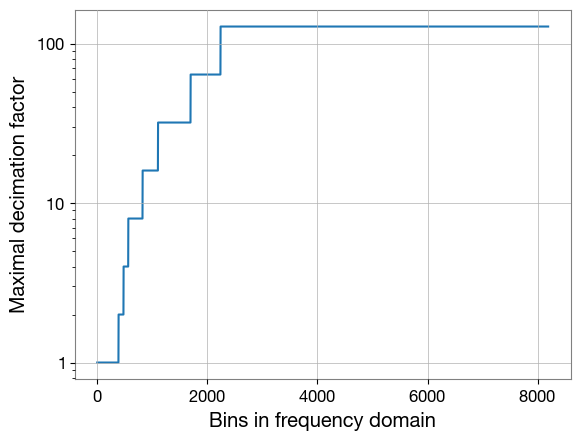

In [14]:
print("Included decimation factors", np.unique(max_dec_factor_array))
plt.plot(max_dec_factor_array)
plt.yscale('log')
plt.xlabel("Bins in frequency domain")
plt.ylabel("Maximal decimation factor");

2. Obtain the values for the location of the bands in frequency domain via `get_band_nodes_for_adaptive_decimation`.

In [15]:
# Get band nodes
initial_downsampling, band_nodes_indices = get_band_nodes_for_adaptive_decimation(
    max_dec_factor_array[ufd.min_idx:],
    max_dec_factor_global=int(delta_f_max / ufd.delta_f),
)
print(band_nodes_indices, len(ufd()[ufd.min_idx:]))
#band_nodes_indices = [i for i in band_nodes_indices if i < len(ufd()[ufd.min_idx:])]
# Transform downsampling factor and band nodes from indices to frequencies
delta_f_initial = ufd.delta_f * initial_downsampling
nodes = ufd()[ufd.min_idx:][np.array(band_nodes_indices)]
print("Old shape of ufd:", ufd().shape)
mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)
print("New shape of ufd:", ufd().shape)

[0, 226, 318, 406, 670, 8030] 8033
Old shape of ufd: (8193,)
New shape of ufd: (8190,)


However, this function has to be modified for the transformer:
- The transformer compresses a specific number of mfd bins into one transformer token. This means that for e.g. `token_size = 16`, the mfd will be divided equally into segments of length `token_size`. 
- Since the frequency information is only passed to the transformer on a token level, we cannot allow variable mfd frequency binning (i.e., different decimation factors) within one token.
- This means that the position of the bands has to coincide with multiples of the `token_size`.

In [16]:
# based on gw.domains.multibanded_frequency_domain.get_band_nodes_for_adaptive_decimation
from dingo.gw.domains.multibanded_frequency_domain import floor_to_power_of_2

def get_band_nodes_for_adaptive_decimation_transformer(
    max_dec_factor_array: np.ndarray, 
    max_dec_factor_global: int = np.inf,
    min_mfd_bins_per_band: int = 1
):
    """
    Sets up adaptive multibanding for decimation. The 1D array max_dec_factor_array has
    the same length as the original, and contains the maximal acceptable decimation
    factors for each bin. max_dec_factor_global further specifies the maximum
    decimation factor.

    Parameters
    ----------
    max_dec_factor_array: np.ndarray
        Array with maximal decimation factor for each bin. Monotonically increasing.
    max_dec_factor_global: int = np.inf
        Global maximum for decimation factor.

    Returns
    -------
    initial_downsampling: int
        Downsampling factor of band 0.
    band_nodes: list[int]
        List with nodes for bands.
        Band j consists of indices [nodes[j]:nodes[j+1].
    """
    if len(max_dec_factor_array.shape) != 1:
        raise ValueError("max_dec_factor_array needs to be 1D array.")
    if not (max_dec_factor_array[1:] >= max_dec_factor_array[:-1]).all():
        raise ValueError("max_dec_factor_array needs to increase monotonically.")
    # TODO: Implement some check to see whether the token size is valid
    print(np.unique(max_dec_factor_array), max_dec_factor_global)
    max_dec_factor_array = np.clip(max_dec_factor_array, None, max_dec_factor_global)
    print(np.unique(max_dec_factor_array))
    N = len(max_dec_factor_array)
    dec_factor = int(max(1, floor_to_power_of_2(max_dec_factor_array[0])))
    band_nodes = [0]
    # Increment by entire token
    upper = dec_factor * min_mfd_bins_per_band
    initial_downsampling = dec_factor
    while upper - 1 < N:
        print('dec factor:', dec_factor, 'dec_factor*2:', 2*dec_factor, '<= max_dec_factor:', max_dec_factor_array[upper], 'upper:', upper, 'N:',N)
        if upper - 1 + dec_factor * min_mfd_bins_per_band >= N:
            # Conclude while loop, append upper as last node
            band_nodes.append(upper)
        elif dec_factor * 2 <= max_dec_factor_array[upper]:
            # Conclude previous band
            band_nodes.append(upper)
            assert (band_nodes[-1] - band_nodes[-2]) % min_mfd_bins_per_band == 0
            print("New band at:", upper)
            # Enter new band
            dec_factor *= 2
        # Increment by entire token
        print("increment by", dec_factor * min_mfd_bins_per_band)
        upper += dec_factor * min_mfd_bins_per_band

    return initial_downsampling, band_nodes

In [17]:
delta_f_max / ufd.delta_f

16.0

[  1.   2.   4.   8.  16.  32.  64. 128.] 16
[ 1.  2.  4.  8. 16.]
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 16 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 32 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 48 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 64 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 80 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 96 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 112 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 128 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 144 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper: 160 N: 8033
increment by 16
dec factor: 1 dec_factor*2: 2 <= max_dec_factor: 1.0 upper:

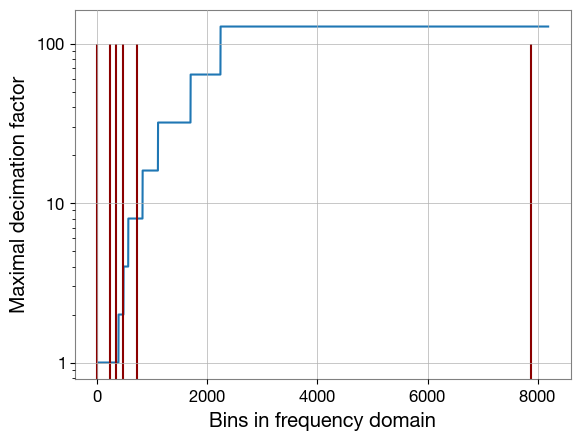

In [18]:
token_size = 16
delta_f_max = 2 # limited due to time-shift
plt.plot(max_dec_factor_array)
# Get band nodes
initial_downsampling, band_nodes_indices = get_band_nodes_for_adaptive_decimation_transformer(
    max_dec_factor_array[ufd.min_idx:],
    max_dec_factor_global=int(delta_f_max / ufd.delta_f), # = delta_f_max * T
    min_mfd_bins_per_band=token_size
)
print(band_nodes_indices, len(ufd()[ufd.min_idx:]))
for node in band_nodes_indices:
    plt.vlines(node, 0, 100, color="darkred")
plt.yscale('log')
plt.xlabel("Bins in frequency domain")
plt.ylabel("Maximal decimation factor");

### How do these bands influence the signal?

In [19]:
ufd = build_domain(uniform_frequency_domain_settings)
# Transform downsampling factor and band nodes from indices to frequencies
delta_f_initial = ufd.delta_f * initial_downsampling
nodes = ufd()[ufd.min_idx:][np.array(band_nodes_indices)]
print("Old shape of ufd:", ufd().shape)
mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)
print("New shape of ufd:", ufd().shape)

Old shape of ufd: (8193,)
New shape of ufd: (8048,)


minimal chirp mass: 15.00664551926338


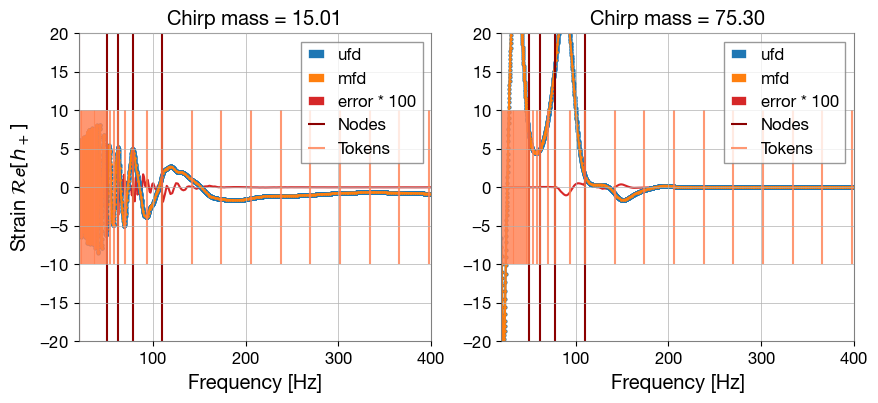

In [20]:
# Get waveform with minimal chirp mass
ind_minimal_chirp_mass = np.argmin(parameters["chirp_mass"])
print("minimal chirp mass:", parameters["chirp_mass"][ind_minimal_chirp_mass])

ind_random = 101
inds = [ind_minimal_chirp_mass, ind_random]

fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(ufd(), a, "-o", markersize=2, label="ufd")
    ax.plot(mfd(), b, "-o", markersize=1, label="mfd")
    ax.plot(mfd(), (b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)
    
    for f in mfd.nodes:
        ax.vlines(f, ymin=-20, ymax=20, color='darkred')
    ax.vlines(f, ymin=-20, ymax=20, color='darkred', label="Nodes")
    
    for f in mfd._f_base_lower[::token_size]:
        ax.vlines(f, ymin=-10, ymax=10, color='coral', alpha=0.8)
    ax.vlines(f, ymin=-10, ymax=10, color='coral', alpha=0.8, label="Tokens")

    ax.legend()
    ax.set_xlim(20, np.max(ufd()))
    ax.set_xlim(20, 400)
    ax.set_ylim(-20, 20)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title(f"Chirp mass = {parameters["chirp_mass"][inds[i]]:.2f}")
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

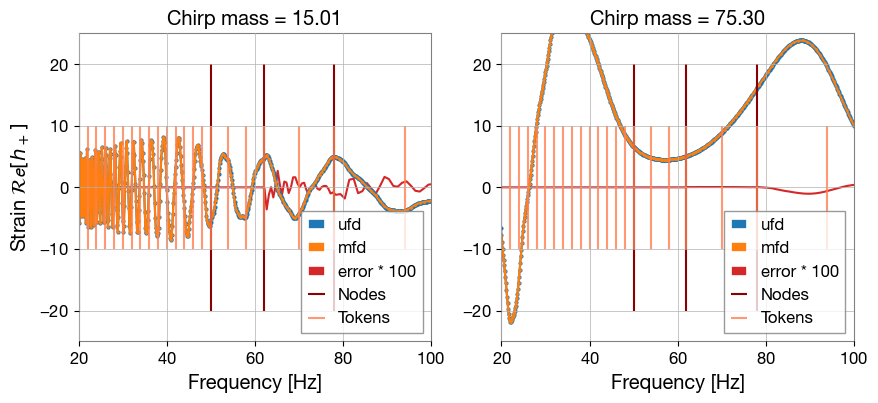

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(ufd(), a, "-o", markersize=2, label="ufd")
    ax.plot(mfd(), b, "-o", markersize=1, label="mfd")
    ax.plot(mfd(), (b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)
    
    for f in mfd.nodes:
        ax.vlines(f, ymin=-20, ymax=20, color='darkred')
    ax.vlines(f, ymin=-20, ymax=20, color='darkred', label="Nodes")
    
    for f in mfd._f_base_lower[::token_size]:
        ax.vlines(f, ymin=-10, ymax=10, color='coral', alpha=0.8)
    ax.vlines(f, ymin=-10, ymax=10, color='coral', alpha=0.8, label="Tokens")

    ax.legend()
    ax.set_xlim(20, np.max(ufd()))
    ax.set_xlim(20, 100)
    ax.set_ylim(-25, 25)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title(f"Chirp mass = {parameters["chirp_mass"][inds[i]]:.2f}")
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

Plot the same thing, but with mfd indices as x-axis

In [22]:
# Find mfd index of nodes in multibanded frequency domain
ind_bands = [np.argmin(np.abs(f - mfd())) for f in nodes]
ind_subbands = [np.argmin(np.abs(f - mfd())) for f in mfd._f_base_lower[::token_size]]

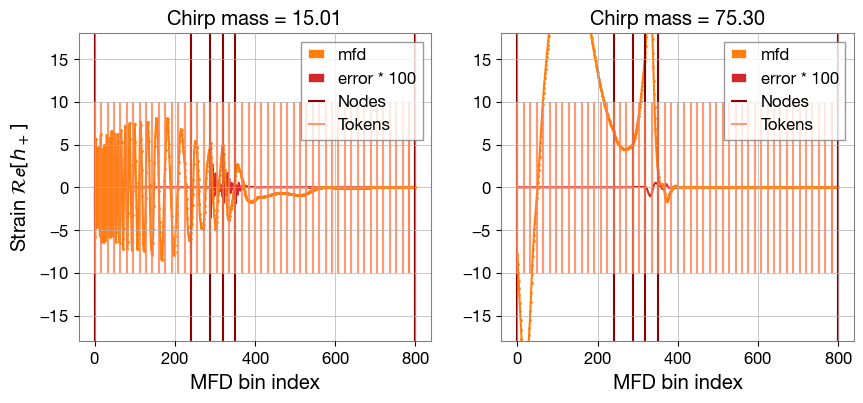

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    a = d[inds[i]][:len(mfd.base_domain)]
    b = mfd.decimate(a)
    b_interp = interp1d(ufd(), a)(mfd())
    
    ax.plot(b, "-o", c="tab:orange", markersize=1, label="mfd")
    ax.plot((b - b_interp) * 100, c="tab:red", label="error * 100", zorder=-5)
    
    for n in ind_bands:
        ax.vlines(n, ymin=-20, ymax=20, color='darkred')
    ax.vlines(n, ymin=-20, ymax=20, color='darkred', label="Nodes")
    
    for n in ind_subbands:
        ax.vlines(n, ymin=-10, ymax=10, color='coral', alpha=0.8)
    ax.vlines(n, ymin=-10, ymax=10, color='coral', alpha=0.8, label="Tokens")

    ax.legend()
    ax.set_ylim(-18, 18)
    ax.set_xlabel("MFD bin index")
    ax.set_title(f"Chirp mass = {parameters["chirp_mass"][inds[i]]:.2f}")
    
axs[0].set_ylabel(r"Strain $\mathcal{Re}[h_+]$")

plt.show()

### Calculate mismatch for bands

In [24]:
# Generate waveform datasets
from dingo.gw.dataset.generate_dataset import generate_waveforms_parallel
from dingo.gw.gwutils import get_mismatch

In [25]:
# ufd = build_domain(uniform_frequency_domain_settings)
# mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)

wfg_ufd = WaveformGenerator(domain=ufd, **wfg_settings)
wfg_mfd = WaveformGenerator(domain=mfd, **wfg_settings)

polarizations_ufd = generate_waveforms_parallel(wfg_ufd, parameters)
polarizations_mfd = generate_waveforms_parallel(wfg_mfd, parameters)

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.


/Users/akofler/Desktop/gravitational_waves/code/dingo-development/dingo/gw/waveform_generator/waveform_generator.py:606: UserWarning: LALsimulation waveform longer than domain's `frequency_array`(8193 vs 8048). Truncating lalsim array.
  warnings.warn(


In [26]:
def calculate_mismatch(
        pols_ufd: np.array,
        pols_mfd: np.array, 
        mfd: MultibandedFrequencyDomain,
        asd_file: str
):
    mismatches = []
    for idx in range(num_samples):
        mism = []
        for k in pols_mfd.keys():
            # extract polarizations at idx
            v1 = pols_mfd[k][idx]#/ mfd.base_domain.noise_std
            v2 = pols_ufd[k][idx]#/ mfd.base_domain.noise_std
            v2_decimated = mfd.decimate(v2)
            # compute mismatch
            mismatch = get_mismatch(
                v1,
                v2_decimated,
                domain=mfd,
                asd_file=asd_file,
            )
            mism.append(mismatch)
        mismatches.append(mism)
    return np.array(mismatches)

mismatches = calculate_mismatch(pols_ufd=polarizations_ufd, pols_mfd=polarizations_mfd, mfd=mfd, asd_file=asd_file)

In [27]:
np.max(mismatches)

3.4469858167685e-05

### Mismatches for waveform models
When waveform models are benchmarked against numerical relativity simulations, minimal/maximal mismatch values are reported, e.g. Fig. 6 in arXiv:2004.06503 for IMRPhenomXPHM.
They report mismatches between approx. $10^{-4} - 10^{-1}$, but the average maximal mismatch is around $10^{-2}$.

This means that a mismatch of $10^{-3}$ should be acceptable.

### Calculate mismatch for Stephen's eyeballed nodes

In [28]:
# Build domain
uniform_frequency_domain_settings = {
    "type": "FrequencyDomain",
    "f_min": 20,
    "f_max": 1065.5,
    "delta_f": 0.125,
}
ufd = build_domain(uniform_frequency_domain_settings)

# Build prior
intrinsic_prior_settings = {
    "mass_1": "bilby.core.prior.Constraint(minimum=10.0, maximum=120.0)",
    "mass_2": "bilby.core.prior.Constraint(minimum=10.0, maximum=120.0)",
    "chirp_mass": "bilby.gw.prior.UniformInComponentsChirpMass(minimum=15.0, maximum=150.0)",
    "mass_ratio": "bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1.0)",
    "phase": "default",
    "a_1": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "a_2": "bilby.core.prior.Uniform(minimum=0.0, maximum=0.99)",
    "tilt_1": "default",
    "tilt_2": "default",
    "phi_12": "default",
    "phi_jl": "default",
    "theta_jn": "default",
    # Reference values for fixed (extrinsic) parameters. These are needed to generate a waveform.
    "luminosity_distance": "100.0",  # Mpc
    "geocent_time": "0.0 ", # s
}
prior = build_prior_with_defaults(intrinsic_prior_settings)

In [29]:
nodes = [20.0, 33.5, 45.5, 57.5, 81.5, 105.5, 1065.5]

ufd = build_domain(uniform_frequency_domain_settings)
mfd = MultibandedFrequencyDomain(nodes=nodes, delta_f_initial=delta_f_initial, base_domain=ufd)

wfg_ufd = WaveformGenerator(domain=ufd, **wfg_settings)
wfg_mfd = WaveformGenerator(domain=mfd, **wfg_settings)

polarizations_ufd = generate_waveforms_parallel(wfg_ufd, parameters)
polarizations_mfd = generate_waveforms_parallel(wfg_mfd, parameters)

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.


/Users/akofler/Desktop/gravitational_waves/code/dingo-development/dingo/gw/waveform_generator/waveform_generator.py:606: UserWarning: LALsimulation waveform longer than domain's `frequency_array`(16385 vs 8524). Truncating lalsim array.
  warnings.warn(


In [30]:
mismatches = calculate_mismatch(pols_ufd=polarizations_ufd, pols_mfd=polarizations_mfd, mfd=mfd, asd_file=asd_file)
np.max(mismatches)

0.00014187655029773705

In [31]:
np.percentile(mismatches, q=99), np.percentile(mismatches, q=90)

(3.850612368298306e-05, 3.048472832989369e-06)